In [1]:
%matplotlib notebook

This requires Python 2.

# Theory

## Lorenz System

\begin{equation}
\dot{x} = \sigma(y-x)
\end{equation}
\begin{equation}
\dot{y} = x(\rho-z) - y
\end{equation}
\begin{equation}
\dot{z} = xy - \beta z
\end{equation}

The Lorenz system consists of a three-dimensional system of nonlinear ordinary differential equations.
Solutions converge neither to a fixed point nor to a limit cycle.
Instead, they converge to a manifold that is neither two- nor three-dimensional - a strange attractor.

The Lorenz system is very sensitive to errors.
Even using very small timesteps, it is impossible to predict the long-term behavior.
This is a combined effect of discretization and truncation errors.
While the Lorenz system is not as high-dimensional as other problems, its chaotic behavior makes it an interesting testcase.

## Boilerplate Code

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import numpy.random as random
random.seed(0)

In [3]:
def odeint(f, state, t):
    res = np.zeros([t.size, len(state)])
    res[0, :] = state[:]
    for i in range(1, t.size):
        dydt = np.array(f(res[i-1, :], t[i-1]))
        res[i, :] = res[i-1, :] + dydt * (t[i]-t[i-1])
    return res

The time integration method `odeint` from SciPy (`scipy.integrate.odeint`) automatically switches between stiff and nonstiff solvers.
While it is very effective, this makes it more difficult to reproduce results.
For example, restarting a time integration may give a different result compared to a single run.
This becomes relevant when using a Kalman filter for data assimilation.
Therefore, the time integration method `odeint` is overwritten with the forward Euler method.

Because the forward Euler method is only a first-order method, smaller timesteps have to be chosen.
Although prediction of the long-term behavior remains impossible, this ensures reliable short-term predictions.
This is relevant because data assimilation involves a number of short-term predictions between consecutive measurements.

## Settings

In [4]:
rho = 28.
sigma = 10.
beta = 8./3.

## Integration

In [5]:
def f(state, t):
  x, y, z = state  # unpack the state vector
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

In [6]:
state_0 = [1., 1., 1.]
t = np.linspace(0., 40., 16001)

states = odeint(f, state_0, t)

The solution at $t=40$ is:

In [7]:
print(states[-1, :])

[ 5.36094704  8.87284443 14.85839386]


This will be the reference solution to the 'identical twin' experiment.

## 3D Plot

<IPython.core.display.Javascript object>


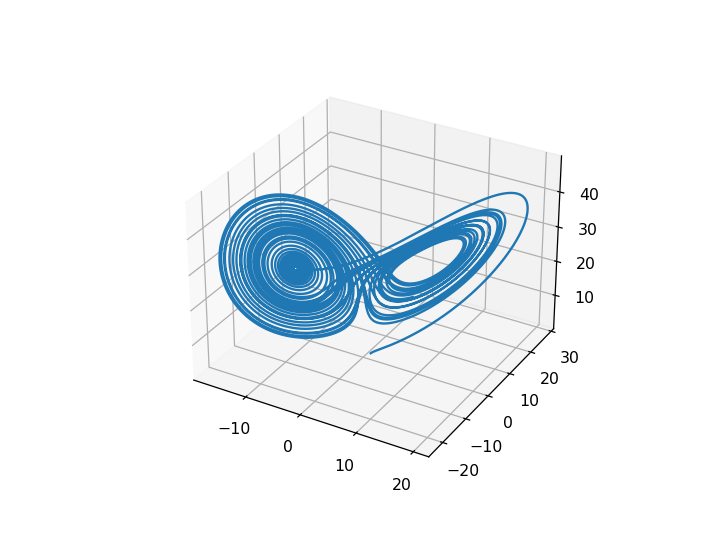

In [8]:
fig = plt.figure(42)
ax = fig.gca(projection='3d')
ax.plot(states[:,0], states[:,1], states[:,2])
fig.show()

## 2D Plots

<IPython.core.display.Javascript object>


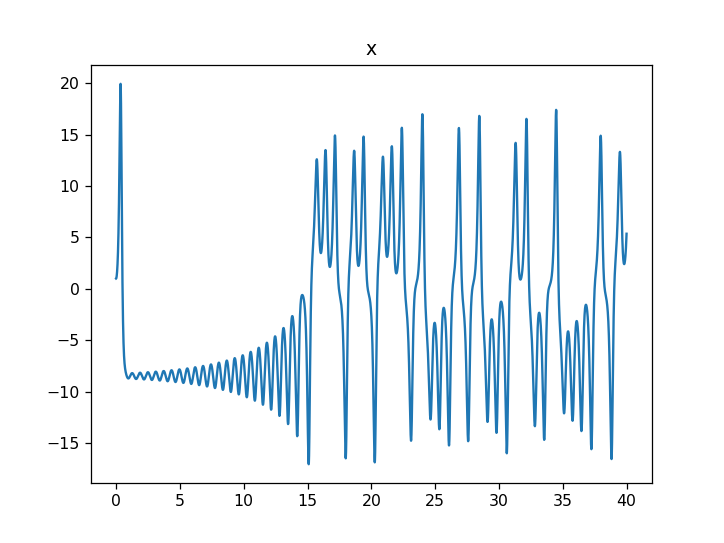

<IPython.core.display.Javascript object>


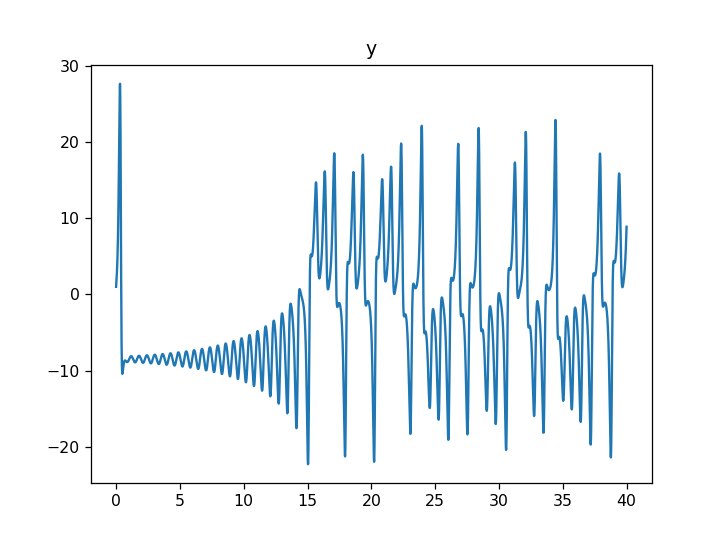

<IPython.core.display.Javascript object>


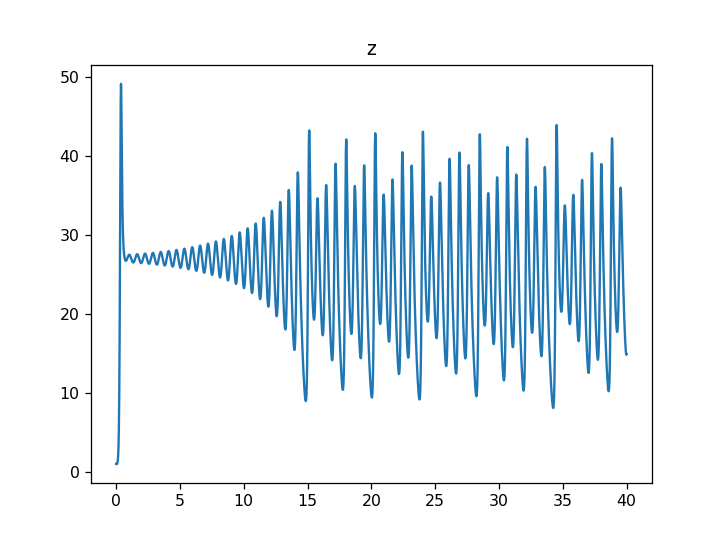

In [9]:
fig_1 = plt.figure(1)
ax_1 = fig_1.gca()
ax_1.plot(t, states[:, 0])
ax_1.set_title('x')
fig_1.show()

fig_2 = plt.figure(2)
ax_2 = fig_2.gca()
ax_2.plot(t, states[:, 1])
ax_2.set_title('y')
fig_2.show()

fig_3 = plt.figure(3)
ax_3 = fig_3.gca()
ax_3.plot(t, states[:, 2])
ax_3.set_title('z')
fig_3.show()

# Ensemble Implementation

## Settings

In [10]:
no_mem = 2  # number of ensemble members

## Integration

In [11]:
class Ensemble(object):
    def __init__(self):
        self.list = []
        
    def __iter__(self):
        return iter(self.list)
    
    def __getitem__(self, key):
        return self.list[key]
    
    def append(self, member):
        self.list.append(member)
    
    def odeint(self, f, t):
        for m_it in self.list:
            m_it.odeint(f, t)
    
class Member(object):
    def __init__(self, state_0):
        self.states = [state_0]

    def odeint(self, f, t):
        states_temp = odeint(f, self.states[-1], t)
        for i in range(1, states_temp.shape[0]):
            self.states.append(states_temp[i, :].tolist())

In [12]:
state_0 = [1., 1., 1.]
cov_0 = 0.1**2 * np.eye(3)
#cov_0 = np.zeros([3, 3])
t = np.linspace(0., 40., 16001)

ensemble = Ensemble()
for i in range(no_mem):
    state = random.multivariate_normal(state_0, cov_0)
    ensemble.append(Member(state))
ensemble.odeint(f, t)

The solution at $t=40$ is:

In [13]:
for m_it in ensemble:
    print(m_it.states[-1])

[-9.740790666496652, -16.407605111949994, 17.350770769265285]
[-9.318831515327526, -12.09185698754566, 24.09979457358014]


## 3D & 2D Plots

<IPython.core.display.Javascript object>


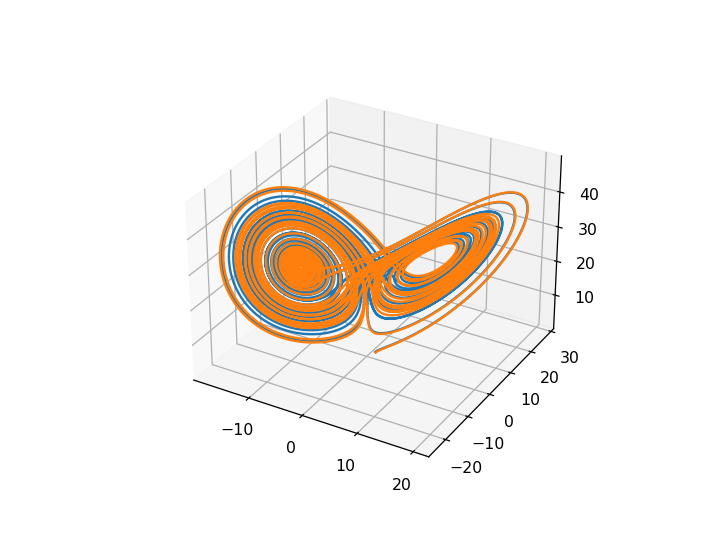

<IPython.core.display.Javascript object>


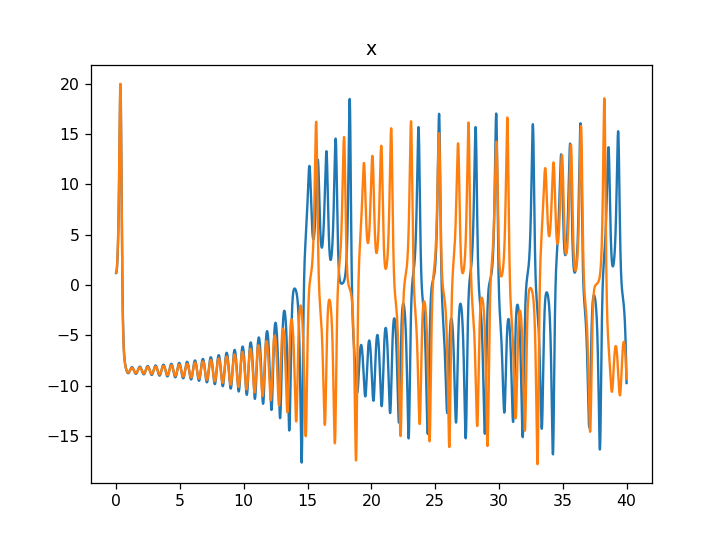

<IPython.core.display.Javascript object>


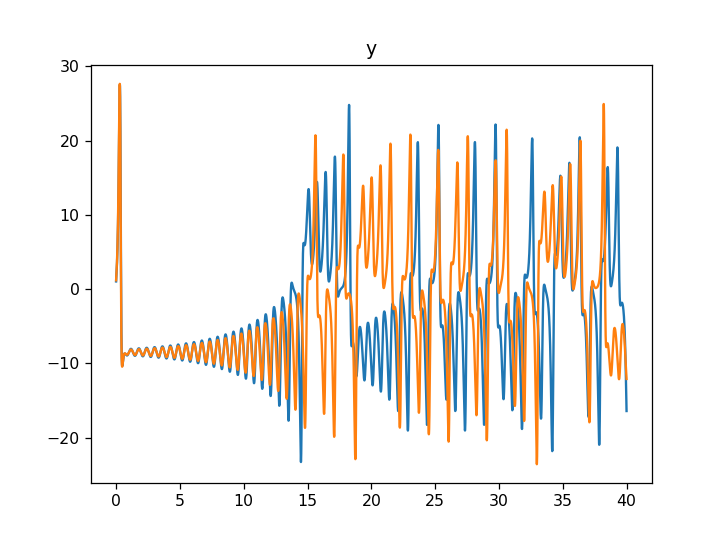

<IPython.core.display.Javascript object>


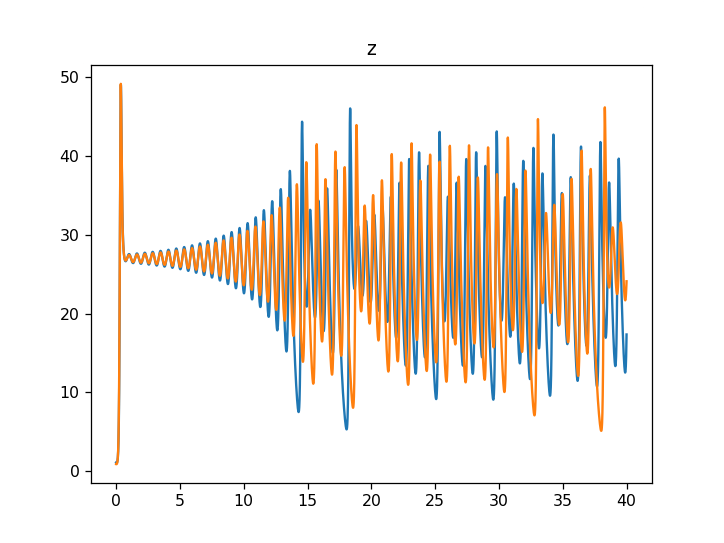

In [14]:
fig = plt.figure(43)
ax = fig.gca(projection='3d')
fig_1 = plt.figure(4)
ax_1 = fig_1.gca()
fig_2 = plt.figure(5)
ax_2 = fig_2.gca()
fig_3 = plt.figure(6)
ax_3 = fig_3.gca()

for m_it in ensemble:
    x_list = np.zeros(t.size)
    y_list = np.zeros(t.size)
    z_list = np.zeros(t.size)
    for t_it in range(t.size):
        state = m_it.states[t_it]
        x_list[t_it] = state[0]
        y_list[t_it] = state[1]
        z_list[t_it] = state[2]
    ax.plot(x_list, y_list, z_list)
    ax_1.plot(t, x_list)
    ax_2.plot(t, y_list)
    ax_3.plot(t, z_list)
    
fig.show()
ax_1.set_title('x')
fig_1.show()
ax_2.set_title('y')
fig_2.show()
ax_3.set_title('z')
fig_3.show()

It can be seen that the Lorenz system is highly sensitive to the initial conditions.
The Kalman filter allows to improve the simulation:
The simulation is treated as a series of 'short' simulations.
After every 'short' simulation, the accumulated error is 'healed' with measurements.

## Error Analysis

<IPython.core.display.Javascript object>


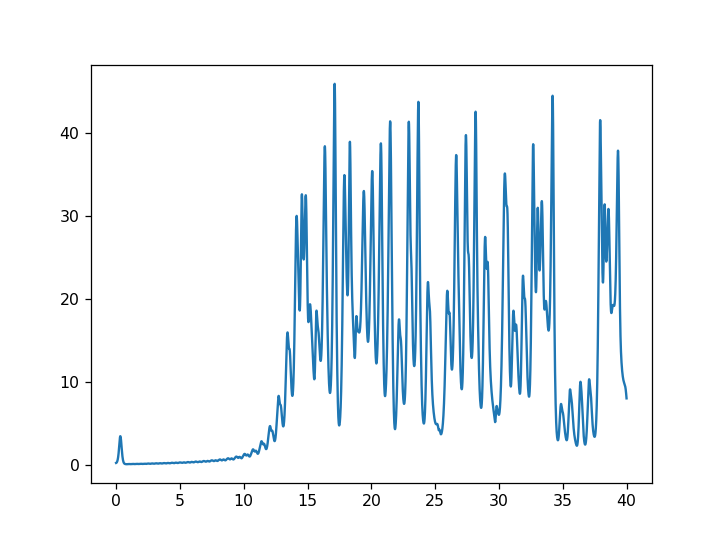

In [15]:
dx_list = np.zeros(t.size)
dy_list = np.zeros(t.size)
dz_list = np.zeros(t.size)
for t_it in range(t.size):
    m_it = ensemble[0]
    state_1 = m_it.states[t_it]
    m_it = ensemble[1]
    state_2 = m_it.states[t_it]
    dx_list[t_it] = state_2[0] - state_1[0]
    dy_list[t_it] = state_2[1] - state_1[1]
    dz_list[t_it] = state_2[2] - state_1[2]

fig_99 = plt.figure(99)
ax_99 = fig_99.gca()
ell_two = dx_list**2
ell_two += dy_list**2
ell_two += dz_list**2
ell_two = np.sqrt(ell_two)
ax_99.plot(t, ell_two)
fig_99.show()

# Ensemble Kalman Filter

## Settings

In [16]:
no_mem = 100               # number of ensemble members
k_meas = 1000              # number of timesteps between measurements
Cee = 0.1**2 * np.eye(3)   # measurement covariance
M = np.eye(3)              # measurement matrix

`k_meas = 1000` corresponds to one measurement every 2.5 seconds.
If `k_meas` is chosen too large, the ensemble Kalman filter is not able to permanently bind the ensemble to the true solution due to the chaotic nature of the Lorenz equations.
Vary `no_mem` and `Cee` to study how the ensemble size and the measurement covariance affect the ensemble Kalman filter.

## Integration

In [17]:
state_0 = [1., 1., 1.]
cov_0 = 0.1**2 * np.eye(3)
#cov_0 = np.zeros([3, 3])
t = np.linspace(0., 40., 16001)

ensemble = Ensemble()
for i in range(no_mem):
    state = random.multivariate_normal(state_0, cov_0)
    ensemble.append(Member(state))

t_it = 0
for meas_it in range(t.size//k_meas):
    # Predict.
    ensemble.odeint(f, t[t_it:t_it+k_meas+1])
    t_it += k_meas
    print(t_it)
    
    # Ensemble covariance a priori.
    sample = [m_it.states[-1] for m_it in ensemble]
    sample = np.array(sample).T
    C = np.cov(sample, ddof=1)
    #print C
    
    # Correct.
    denom = Cee + np.matmul(M, np.matmul(C, M.T))
    for m_it in ensemble:
        # Measurement.
        d = random.multivariate_normal(states[t_it], Cee)

        # u.
        state = m_it.states[-1]
        dstate = d - np.matmul(M, state)
        dstate = la.solve(denom, dstate)
        dstate = np.matmul(M.T, dstate)
        dstate = np.matmul(C, dstate)
        m_it.states[-1] = state + dstate
    
    # Ensemble covariance a posteriori.
    sample = [m_it.states[-1] for m_it in ensemble]
    sample = np.array(sample).T
    C_post = np.cov(sample, ddof=1)
    print(C_post)
    
    # Ensemble covariance a posteriori (theoretical).
    dC = np.matmul(M, C)
    dC = la.solve(denom, dC)
    dC = np.matmul(M.T, dC)
    dC = np.matmul(C, dC)
    C_th = C - dC
    print(C_th)

1000
[[ 0.00083219  0.00041183 -0.00158007]
 [ 0.00041183  0.00064049 -0.00018968]
 [-0.00158007 -0.00018968  0.00380335]]
[[ 0.00096795  0.00045203 -0.00187313]
 [ 0.00045203  0.00061212 -0.00033111]
 [-0.00187313 -0.00033111  0.00436174]]
2000
[[ 0.00108019  0.00078047 -0.00174373]
 [ 0.00078047  0.00163562  0.00024406]
 [-0.00174373  0.00024406  0.00492569]]
[[ 0.00099657  0.0006845  -0.00165924]
 [ 0.0006845   0.00160075  0.00044732]
 [-0.00165924  0.00044732  0.00499038]]
3000
[[ 0.00124332  0.00137338 -0.00137849]
 [ 0.00137338  0.00311252  0.00086281]
 [-0.00137849  0.00086281  0.00509544]]
[[ 0.0015369   0.00160494 -0.00183873]
 [ 0.00160494  0.00315173  0.00028559]
 [-0.00183873  0.00028559  0.00549693]]
4000
[[ 0.00190916  0.00243696 -0.00166347]
 [ 0.00243696  0.00429766 -0.000122  ]
 [-0.00166347 -0.000122    0.00482456]]
[[ 1.98498767e-03  2.44532921e-03 -1.87632675e-03]
 [ 2.44532921e-03  4.33124412e-03 -8.87998672e-05]
 [-1.87632675e-03 -8.87998672e-05  5.52030537e-03]]


The a posteriori ensemble covariance matrix is not used in the ensemble Kalman Filter.
But it is useful for debugging the analysis scheme.

The solution at $t=40$ is:

In [18]:
print(np.mean([m_it.states[-1] for m_it in ensemble], 0))

[ 5.36430525  8.8714285  14.87160284]


## 3D & 2D Plots

<IPython.core.display.Javascript object>


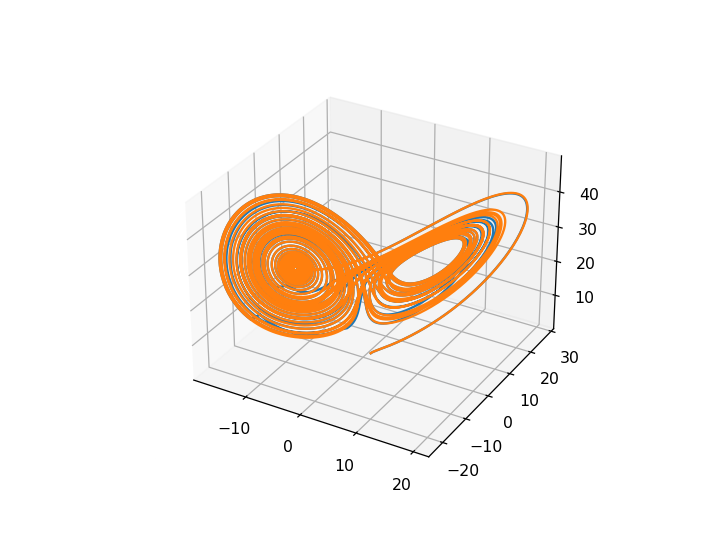

<IPython.core.display.Javascript object>


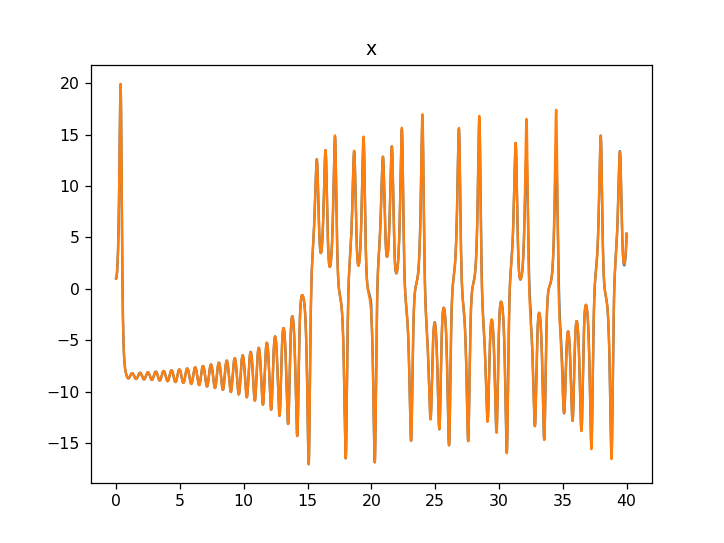

<IPython.core.display.Javascript object>


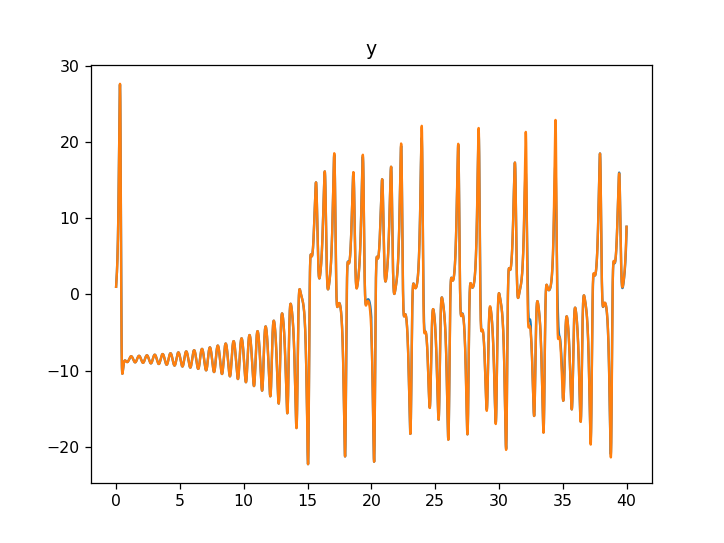

<IPython.core.display.Javascript object>


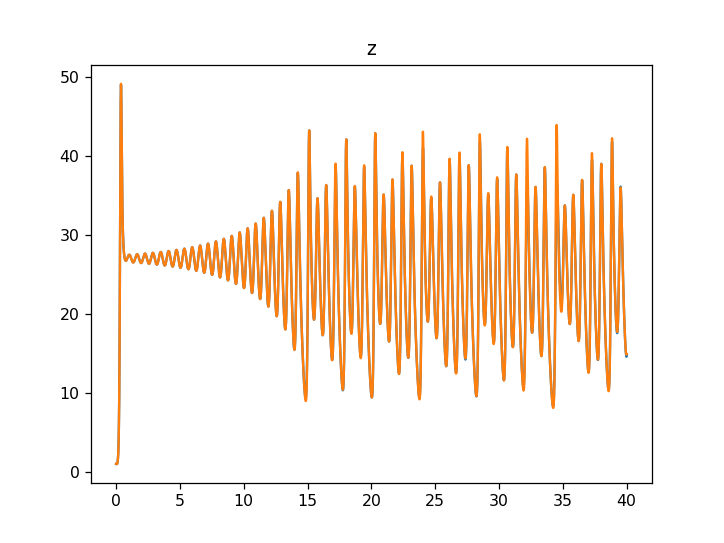

In [19]:
fig = plt.figure(44)
ax = fig.gca(projection='3d')
fig_1 = plt.figure(7)
ax_1 = fig_1.gca()
fig_2 = plt.figure(8)
ax_2 = fig_2.gca()
fig_3 = plt.figure(9)
ax_3 = fig_3.gca()

x_list = np.zeros(t.size)
y_list = np.zeros(t.size)
z_list = np.zeros(t.size)
for t_it in range(t.size):
    x_list[t_it], y_list[t_it], z_list[t_it] = np.mean([m_it.states[t_it] for m_it in ensemble], 0)

ax.plot(x_list, y_list, z_list)
ax.plot(states[:, 0], states[:, 1], states[:, 2])
ax_1.plot(t, x_list)
ax_2.plot(t, y_list)
ax_3.plot(t, z_list)
ax_1.plot(t, states[:, 0])
ax_2.plot(t, states[:, 1])
ax_3.plot(t, states[:, 2])

fig.show()
ax_1.set_title('x')
fig_1.show()
ax_2.set_title('y')
fig_2.show()
ax_3.set_title('z')
fig_3.show()

## Error Analysis

<IPython.core.display.Javascript object>


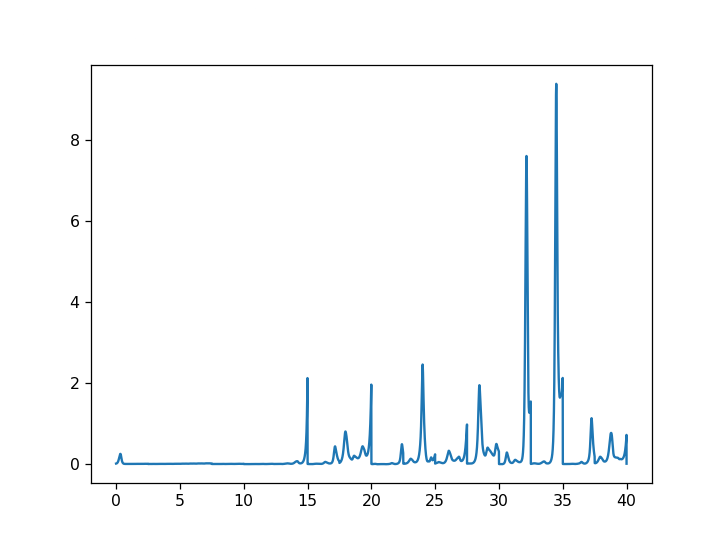

In [20]:
fig_100 = plt.figure(100)
ax_100 = fig_100.gca()
ell_two = (x_list-states[:, 0])**2
ell_two += (y_list-states[:, 1])**2
ell_two += (z_list-states[:, 2])**2
ell_two = np.sqrt(ell_two)
ax_100.plot(t, ell_two)
fig_100.show()

## Integration with Square-Root Kalman Filter

In [21]:
state_0 = [1., 1., 1.]
cov_0 = 0.1**2 * np.eye(3)
#cov_0 = np.zeros([3, 3])
t = np.linspace(0., 40., 16001)

ensemble = Ensemble()
for i in range(no_mem):
    state = random.multivariate_normal(state_0, cov_0)
    ensemble.append(Member(state))

t_it = 0
for meas_it in range(t.size//k_meas):
    # Predict.
    ensemble.odeint(f, t[t_it:t_it+k_meas+1])
    t_it += k_meas
    print(t_it)
    
    # Ensemble mean and covariance a priori.
    sample = [m_it.states[-1] for m_it in ensemble]
    sample = np.array(sample).T
    mu = np.mean(sample, 1)
    C = np.cov(sample, ddof=1)
    #print C
    
    # Measurement.
    d = random.multivariate_normal(states[t_it], Cee)
    denom = Cee + np.matmul(M, np.matmul(C, M.T))
    
    # Correct.
    dmu = d - np.matmul(M, mu)
    dmu = la.solve(denom, dmu)
    dmu = np.matmul(M.T, dmu)
    dmu = np.matmul(C, dmu)
    mu_post = mu + dmu
    
    dsample = sample.copy()
    for m_ctr in range(no_mem):
        dsample[:, m_ctr] -= mu
    S = np.matmul(M, dsample)
    temp = la.solve((no_mem-1)*denom, S)
    temp = np.matmul(S.T, temp)
    w, V = la.eig(temp)
    w = w.real
    V = V.real
    
    dsample_post = np.diag(np.sqrt(1-w))
    dsample_post = np.matmul(dsample_post, V.T)
    dsample_post = np.matmul(V, dsample_post)
    dsample_post = np.matmul(dsample, dsample_post)
    for m_ctr in range(no_mem):
        m_it = ensemble[m_ctr]
        m_it.states[-1] = mu_post + dsample_post[:, m_ctr]
    
    # Ensemble covariance a posteriori.
    C_post = np.cov(dsample_post, ddof=1)
    print(C_post)
    
    # Ensemble covariance a posteriori (theoretical).
    dC = np.matmul(M, C)
    dC = la.solve(denom, dC)
    dC = np.matmul(M.T, dC)
    dC = np.matmul(C, dC)
    C_th = C - dC
    print(C_th)

1000
[[ 0.00104689  0.00054216 -0.00195322]
 [ 0.00054216  0.00064082 -0.00052409]
 [-0.00195322 -0.00052409  0.00430412]]
[[ 0.00104689  0.00054216 -0.00195322]
 [ 0.00054216  0.00064082 -0.00052409]
 [-0.00195322 -0.00052409  0.00430412]]
2000
[[ 0.0010671   0.00064685 -0.00188778]
 [ 0.00064685  0.00141704  0.00028134]
 [-0.00188778  0.00028134  0.0053229 ]]
[[ 0.0010671   0.00064685 -0.00188778]
 [ 0.00064685  0.00141704  0.00028134]
 [-0.00188778  0.00028134  0.0053229 ]]
3000
[[ 0.00143223  0.0014167  -0.00181595]
 [ 0.0014167   0.00293786  0.00046702]
 [-0.00181595  0.00046702  0.00563667]]
[[ 0.00143223  0.0014167  -0.00181595]
 [ 0.0014167   0.00293786  0.00046702]
 [-0.00181595  0.00046702  0.00563667]]
4000
[[ 0.00204965  0.00247504 -0.00200161]
 [ 0.00247504  0.00430763 -0.00022551]
 [-0.00200161 -0.00022551  0.00559674]]
[[ 0.00204965  0.00247504 -0.00200161]
 [ 0.00247504  0.00430763 -0.00022551]
 [-0.00200161 -0.00022551  0.00559674]]
5000
[[ 0.00247413  0.00360952 -0.00

The a posteriori ensemble covariance matrix is not used in the ensemble Kalman Filter.
But it is useful for debugging the analysis scheme.

The solution at $t=40$ is:

In [22]:
print(np.mean([m_it.states[-1] for m_it in ensemble], 0))

[ 5.41973345  8.83006727 14.83109045]


## 3D & 2D Plots

<IPython.core.display.Javascript object>


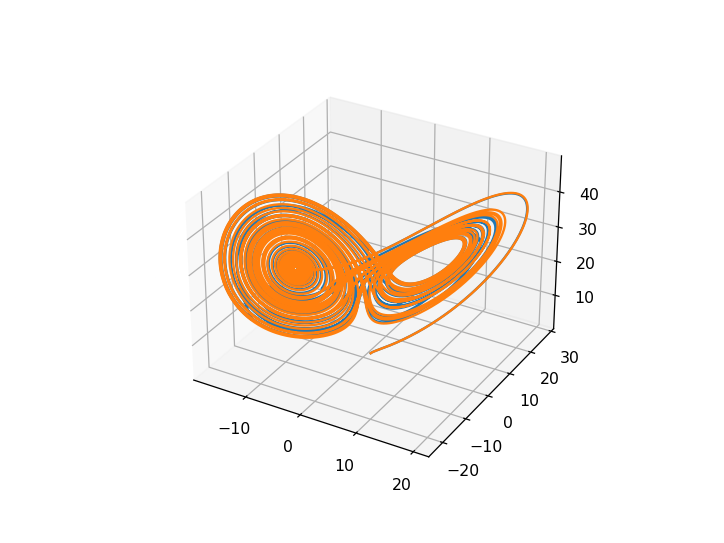

<IPython.core.display.Javascript object>


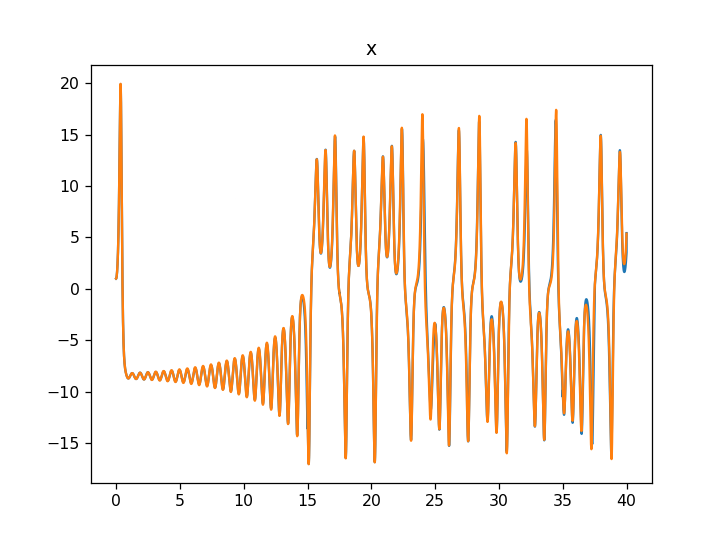

<IPython.core.display.Javascript object>


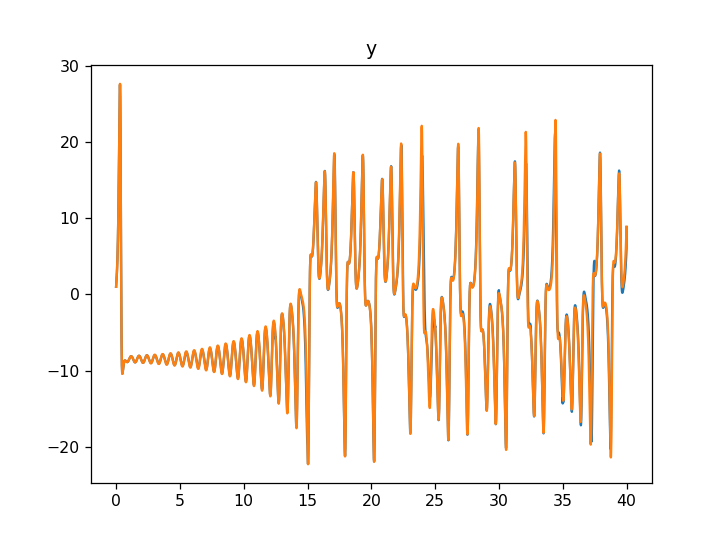

<IPython.core.display.Javascript object>


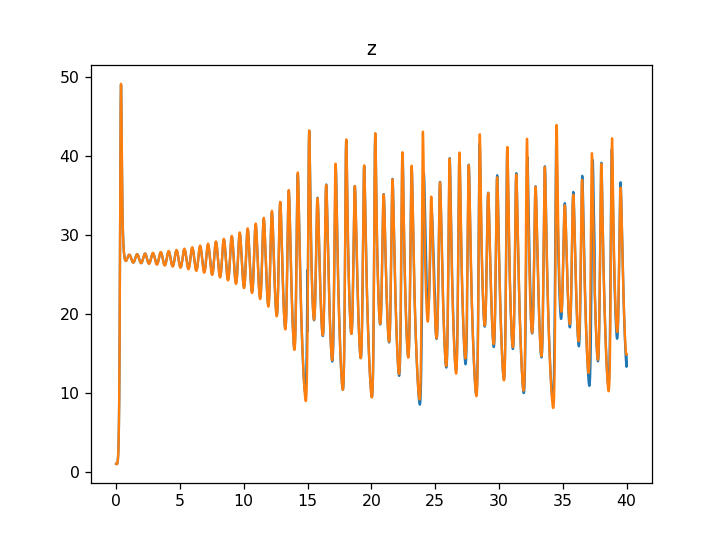

In [23]:
fig = plt.figure(45)
ax = fig.gca(projection='3d')
fig_1 = plt.figure(10)
ax_1 = fig_1.gca()
fig_2 = plt.figure(11)
ax_2 = fig_2.gca()
fig_3 = plt.figure(12)
ax_3 = fig_3.gca()

x_list = np.zeros(t.size)
y_list = np.zeros(t.size)
z_list = np.zeros(t.size)
for t_it in range(t.size):
    x_list[t_it], y_list[t_it], z_list[t_it] = np.mean([m_it.states[t_it] for m_it in ensemble], 0)

ax.plot(x_list, y_list, z_list)
ax.plot(states[:, 0], states[:, 1], states[:, 2])
ax_1.plot(t, x_list)
ax_2.plot(t, y_list)
ax_3.plot(t, z_list)
ax_1.plot(t, states[:, 0])
ax_2.plot(t, states[:, 1])
ax_3.plot(t, states[:, 2])

fig.show()
ax_1.set_title('x')
fig_1.show()
ax_2.set_title('y')
fig_2.show()
ax_3.set_title('z')
fig_3.show()

## Error Analysis

<IPython.core.display.Javascript object>


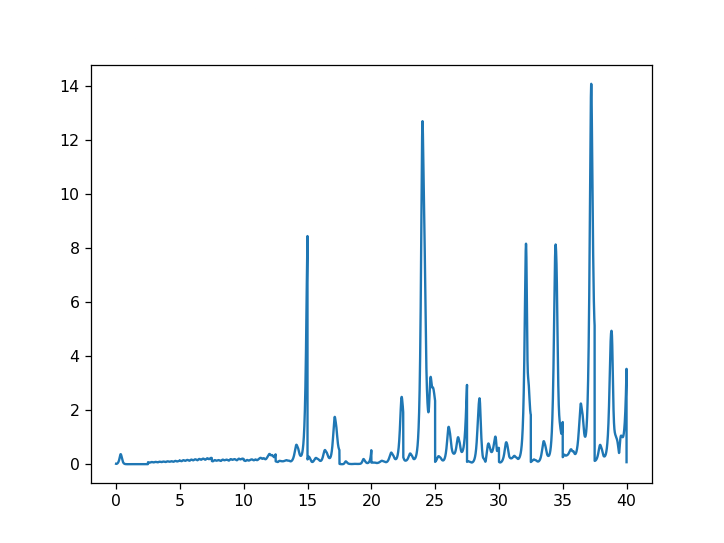

In [24]:
fig_100 = plt.figure(101)
ax_100 = fig_100.gca()
ell_two = (x_list-states[:, 0])**2
ell_two += (y_list-states[:, 1])**2
ell_two += (z_list-states[:, 2])**2
ell_two = np.sqrt(ell_two)
ax_100.plot(t, ell_two)
fig_100.show()